In [21]:
# imports, initalize output path as none 
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tkinter import Tk, filedialog
import openpyxl
from openpyxl import load_workbook
import shutil
output_path = None

In [22]:
def get_output_directory():# Get the output directory from user input
    """
    This function prompts the user to select an output directory using a graphical file dialog.

    Returns:
        str: The path of the selected output directory.

    Raises:
        Exception: If no directory is selected by the user.
    """
    # Initialize the Tkinter root window
    root = Tk()

    # Lift the root window to the top
    root.lift()
    root.attributes('-topmost', True)
    
    # Open a directory selection dialog and store the selected directory
    directory = filedialog.askdirectory(title="Select Output Directory", parent=root)

    # Withdraw the root window after the dialog is closed
    root.withdraw()

    # Check if a directory was selected
    if directory:
        return directory
    else:
        raise Exception("No directory selected.")  

In [23]:
def screen_data(df, features, wtloss): # data screening function
    """
    Creates a subset of the desired features and applies listwise deletion (deletes rows if any feature is missing).
    
    Parameters:
        df (DataFrame): Original DataFrame.
        features (list): List of feature column names to retain.
        wtloss (str): Column name of the target variable to check correlations with.
    
    Returns:
        subset (DataFrame): Processed DataFrame after listwise deletion.
    """
    subset = df[features + [wtloss]].dropna(axis=0, how='any')
    
    if subset.empty:
        print(f"Dataset is empty.")
        return None

    return subset

In [24]:
def significance_test(df, corr_matrix, target_column, alpha): # test significance of pearson correlation coefficient and return results
    """
    Conducts a standard t-test to check the significance of each Pearson correlation coefficient 
    with respect to the target column using a specified significance level.
    
    Parameters:
        df (DataFrame): DataFrame containing the data.
        corr_matrix (DataFrame): Correlation matrix of the data.
        target_column (str): Column name of the target variable.
        alpha (float): Significance level threshold.
        
    Returns:
        results_df (DataFrame): DataFrame containing coefficients, p-values and significance.
    """
    # print(f"Standard t-test to check significance of each Pearson correlation coefficient with respect to '{target_column}' using significance level {alpha}")
    
    correlations = corr_matrix[target_column]
    p_values = []
    for column in df.columns:
        if column != target_column:
            corr_coeff = correlations[column]
            df_residuals = len(df) - 2
            t_statistic = corr_coeff * np.sqrt(df_residuals) / np.sqrt(1 - corr_coeff ** 2)
            p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df_residuals))
            p_values.append(p_value)
        else:
            p_values.append(np.nan)  # not testing the target column against itself

    p_values_df = pd.DataFrame(p_values, index=df.columns, columns=['p-value'])
    significant = p_values_df['p-value'] < alpha
    significant[target_column] = False  # self-correlation set to False
            
    results_df = pd.DataFrame({
        'Correlation Coefficient': correlations,
        'Significant': significant
    })
    # Sort by significance (True first) and then by descending correlation
    results_df = results_df.sort_values(by=['Significant', 'Correlation Coefficient'], ascending=[False, False])
    return results_df

In [25]:
def plot_heatmap(output_path, saveName, wtloss, corr_mat): # heat map plotting and saving for correlation matrices
    """
    This function plots a heatmap of the correlation matrix for the given weight loss data.

    Parameters:
        weight_loss_data (str): The dataset or context description for weight loss data.
        correlation_matrix (DataFrame): The correlation matrix to be plotted as a heatmap.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Create a heatmap using seaborn
    sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})

    # Add title and labels
    plt.title(f'Correlation Matrix Heatmap for {wtloss}', fontsize=15)
    plt.xticks(rotation=45, ha='right')  # Rotate labels to prevent overlapping
    plt.yticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Save the figure to the specified folder
    plt.savefig(os.path.join(output_path, f"correlation_heatmap_{saveName}.png"))
    plt.show()


In [26]:
def save_to_excel(output_file, saveName, results_df,corr_mat): # saves a df to a previosly created excel work book
    """
    Save results and correlation matrix to an existing Excel workbook.

    Parameters:
        output_file (str): The path to the output Excel file.
        sheet_name (str): The name of the sheet to write data to.
        results_df (pd.DataFrame): The dataframe containing results.
        corr_mat (pd.DataFrame): The correlation matrix dataframe.
    """
    # Create a Pandas Excel writer using openpyxl as the engine
    with pd.ExcelWriter(output_file, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:

        # Write the results_df to the specified sheet
        results_df.to_excel(writer, sheet_name=saveName,startrow=2, index=True)
        writer.sheets[saveName].cell(row=1, column=1, value=f"Pearson correlation coefficients and results of significance test for {saveName}")    
    
    with pd.ExcelWriter(output_file, mode='a', engine='openpyxl', if_sheet_exists='overlay') as writer:    
        
        # Calculate the starting row for the correlation matrix
        start_row = results_df.shape[0] + 6  # +2 to add 1 empty row between the two dataframes
        writer.sheets[saveName].cell(row=start_row, column=1, value=f"correlation matrix with respect to screening based on {saveName}") 
            
        # Write the corr_mat to the same sheet starting from 'start_row'
        corr_mat.to_excel(writer, sheet_name=saveName, startrow=start_row+1, index=True)

In [27]:
def outputResults(output_path, output_file, saveName, results_df, alpha, wtloss, corr_mat):# handle all post process result saving and display 
    """
    Handles all post-process result saving and display tasks.

    Parameters:
        output_path (str): Directory where output files will be saved.
        output_file (str): Path to the Excel file where results will be saved.
        save_name (str): The name under which to save the results.
        results_df (pd.DataFrame): DataFrame containing the results to be output.
        alpha (float): Significance level used in the tests.
        wtloss (str): The parameter with respect to which the tests are conducted.
        corr_mat (pd.DataFrame): Correlation matrix to be saved and visualized.

    Returns:
        None    
    """
    print(f"\nSignificance and Correlation Test Results using alpha =", alpha, ' with respect to', wtloss, ':\n', results_df,'\n')
    save_to_excel(output_file, saveName, results_df,corr_mat)
    plot_heatmap(output_path,saveName, wtloss, corr_mat)    

In [28]:
def save_location_pre_processing(output_path):
    """
    Prepares the output directory and file for correlation significance results.

    Parameters:
        output_path (str, optional): The base directory where results will be saved. Defaults to None.

    Returns:
        tuple: A tuple containing the output directory path and the output file path.
    """
    # create output path and file 
    if output_path is None:
        output_path = get_output_directory()
        output_path = f"{output_path}/correlation_significance_results"
        output_file = f"{output_path}/correlation_significance_test_results.xlsx"

  
    # Check if the directory exists and replace it 
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
        
    os.makedirs(output_path)

    # Check if the file already exists
    if os.path.isfile(output_file):
        # Remove the existing file
        os.remove(output_file)
    return output_path, output_file
    
    

In [29]:
# data set loading, feature definitions,alpha for significance test

# Load the Excel file
df = pd.read_excel('Project Dataset.xlsx', sheet_name='data', engine='openpyxl')

# defining the desired weight loss reporting methods for screening
wtlossreporting= [['BOD (% /day)','BOD'], ['wt. loss (% /day)','WT']]
         
# defining significance level 
alpha = 0.1

# renaming features for clarity
df = df.rename(columns={'BOD (% day-1)': 'BOD (% /day)',
                        'wt. loss (% day-1)':'wt. loss (% /day)',                        
                        'den (g mL-1)':'den (g/mL)',
                        "% cryst": "% crystallinity", 
                        "enthalpy (J g-1)": "enthalpy (J/g)", 
                        "LogP(SA)-1 (Å-2)": "LogP/(SA)", 
                        "Mw (kg mol-1)": "Mw (kg/mol)",
                        "Mn (kg mol-1)": "Mn (kg/mol)",
                        })

# defining the subset features
features = ['den (g/mL)', 
            'total sp3 C', 
            '% sp3 C', 
            'LogP/(SA)',
            'Mw (kg/mol)', 
            'Mn (kg/mol)', 
            'Mw/Mn',
            'Tg (°C)', 
            'Tm (°C)', 
            '% crystallinity', 
            'enthalpy (J/g)', 
            '(Tw-Tg)/(LogP/SA)'
            ]


Conducting analysis with respect to: BOD (% /day)
Subset size: (15, 13)

Significance and Correlation Test Results using alpha = 0.1  with respect to BOD (% /day) :
                    Correlation Coefficient  Significant
Tg (°C)                          -0.553801         True
% crystallinity                  -0.595591         True
Tm (°C)                          -0.646002         True
BOD (% /day)                      1.000000        False
% sp3 C                           0.386571        False
(Tw-Tg)/(LogP/SA)                 0.339553        False
LogP/(SA)                         0.318224        False
total sp3 C                       0.259687        False
enthalpy (J/g)                   -0.267946        False
Mw (kg/mol)                      -0.297775        False
Mn (kg/mol)                      -0.311399        False
den (g/mL)                       -0.381368        False
Mw/Mn                            -0.431366        False 



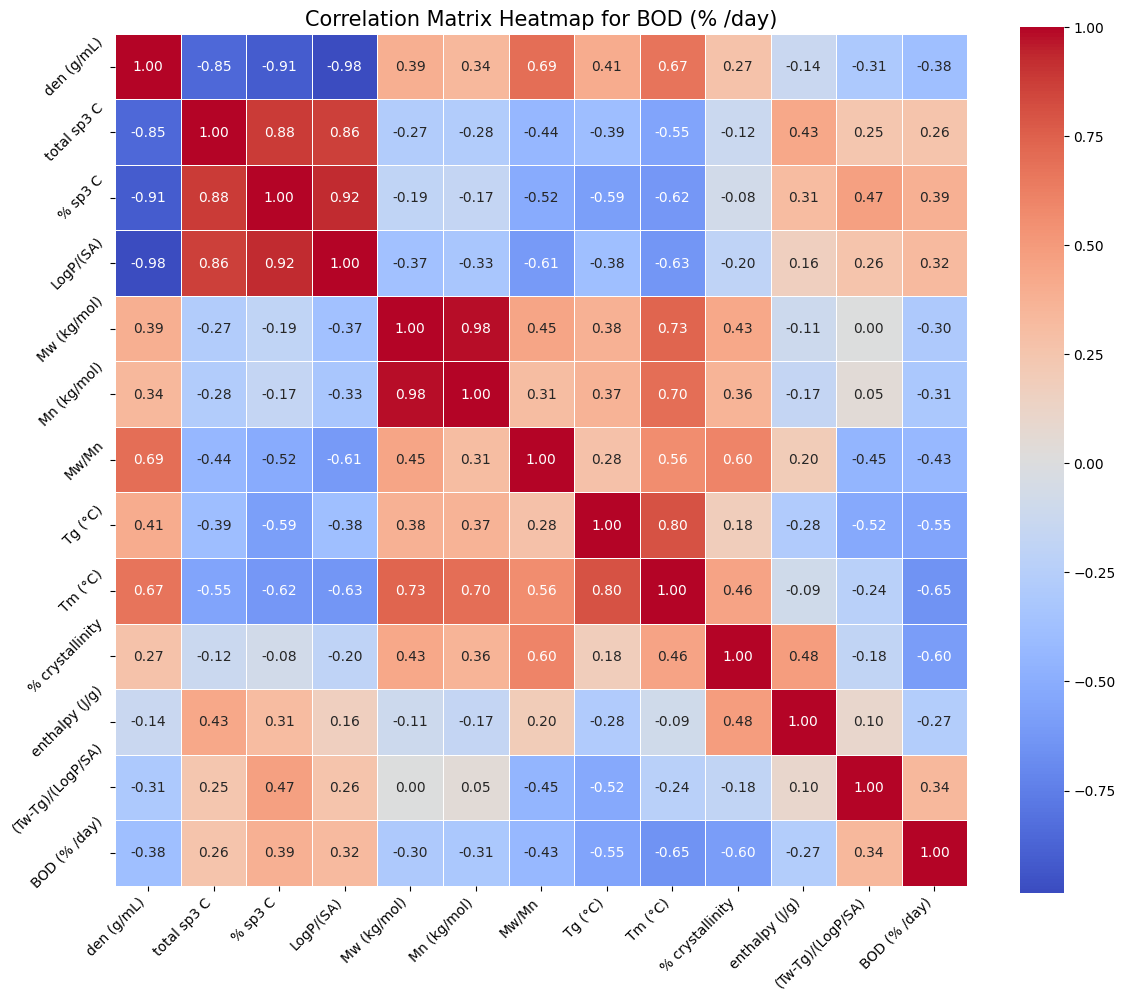

Conducting analysis with respect to: wt. loss (% /day)
Subset size: (65, 13)

Significance and Correlation Test Results using alpha = 0.1  with respect to wt. loss (% /day) :
                    Correlation Coefficient  Significant
total sp3 C                       0.329406         True
Mw (kg/mol)                      -0.210163         True
Mn (kg/mol)                      -0.218463         True
Tg (°C)                          -0.295374         True
Tm (°C)                          -0.358992         True
wt. loss (% /day)                 1.000000        False
Mw/Mn                             0.125908        False
(Tw-Tg)/(LogP/SA)                 0.124088        False
LogP/(SA)                         0.119470        False
% sp3 C                           0.096774        False
den (g/mL)                       -0.087104        False
% crystallinity                  -0.107286        False
enthalpy (J/g)                   -0.140959        False 



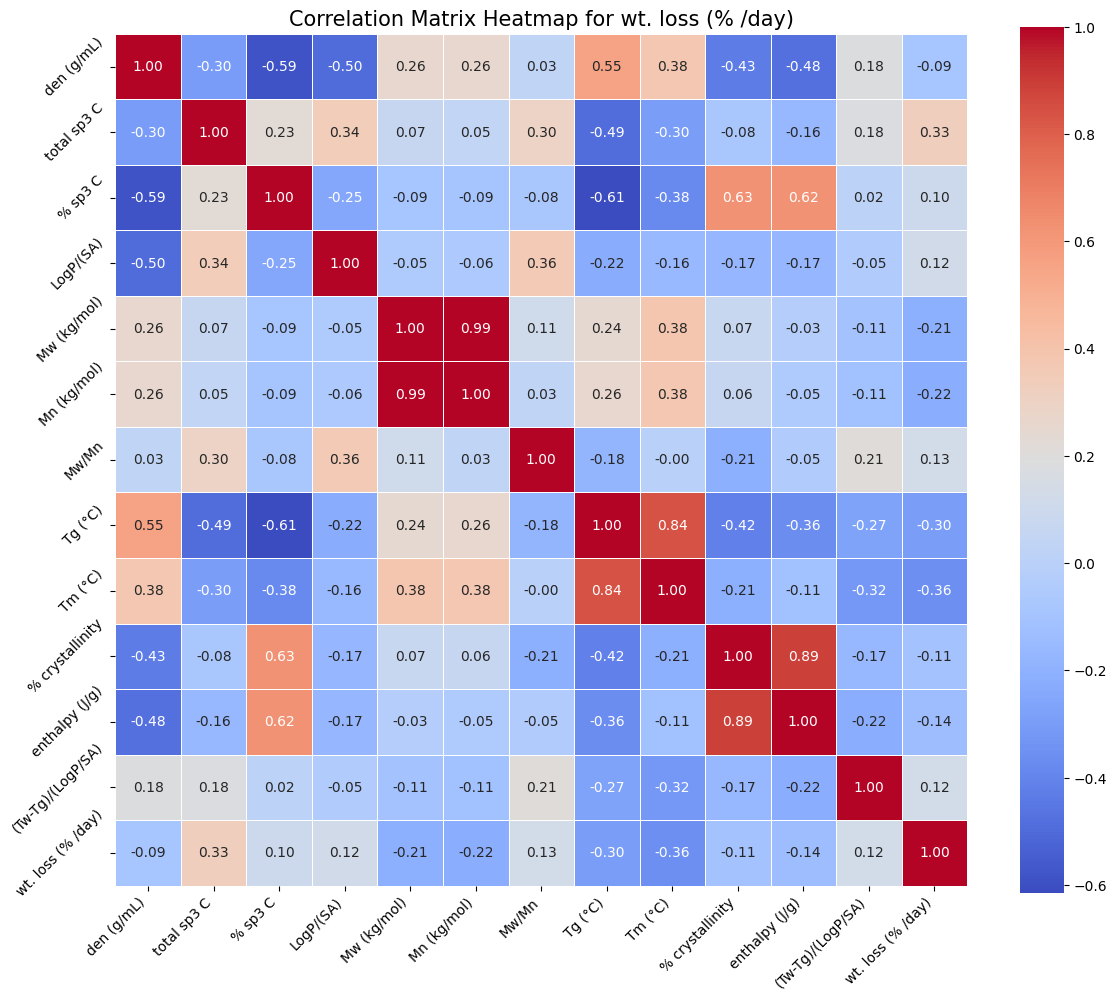

In [ ]:
#handle all data processing 
output_path, output_file = save_location_pre_processing(output_path)

# Create a new workbook
wb = openpyxl.Workbook()
# Save the workbook to the specified file
wb.save(output_file)   

for [wtloss, saveName] in wtlossreporting:   
    
    print("Conducting analysis with respect to:", wtloss) 
        
    data = screen_data(df, features, wtloss)
        
    if data is not None:
        corr_mat = data.corr()
        print(f"Subset size: {data.shape}")
        results_df = significance_test(data, corr_mat, wtloss, alpha)
        outputResults(output_path, output_file, saveName, results_df, alpha, wtloss, corr_mat)
    else:
        print("Encountered unhandled error for {wtloss} analysis")


# Load the workbook
wb = load_workbook(output_file)

# Remove the first sheet
wb.remove(wb[wb.sheetnames[0]])

# Save the workbook to apply changes
wb.save(output_file)
